# Counterfactual Analysis of Target Temperature Management (TTM) Protocols

## Introduction
This notebook explores the impact of different Target Temperature Management (TTM) protocols on patient outcomes, with the aim of identifying optimal treatments for specific patient subpopulations. By evaluating counterfactual scenarios, we assess how changes in TTM protocols—specifically, TTM at 33°C, TTM at 36°C, and no TTM—affect the model's predictions for each patient. Through this analysis, we aim to:
- Determine the best predicted outcome per patient under each TTM protocol.
- Identify distinct patient groups that benefit most from TTM 33, TTM 36, or no TTM.
- Evaluate if the changes are statistically significant between original and counterfactual groups.
- Explore shared characteristics within each group to better understand optimal TTM conditions.

## Table of Contents
1. [Setup & Imports](#setup-imports)
2. [Data Loading and Preparation](#data-loading-preparation)
3. [Define Counterfactual Scenarios for TTM Protocols](#define-counterfactual-scenarios)
4. [Generate and Compare Predictions for Each Protocol](#generate-and-compare-predictions)
5. [Group Patients by Optimal Protocol](#group-patients-by-optimal-protocol)
6. [Significance Testing of Prediction Changes](#significance-testing)
7. [Analysis of Commonalities Within Each Group](#group-commonalities-analysis)

---

Each section provides a step-by-step approach to answer our main questions and assess the impact of different TTM protocols on patient outcomes. By the end of this notebook, we will gain insights into which TTM protocol is most beneficial for distinct patient groups and identify key characteristics that define these groups.


## 1. Setup & Imports <a id="setup-imports"></a>

In this section, we import the necessary libraries for data manipulation, model prediction, statistical testing, and visualization. These libraries will enable us to efficiently load, process, and analyze data, as well as interpret model outputs.

- **NumPy and Pandas**: Essential for data handling and manipulation.
- **TensorFlow**: Used to load and work with the neural network model for generating predictions under different TTM protocols.
- **sklearn**: Provides metrics for evaluating model performance.
- **scipy.stats**: Useful for conducting statistical tests to evaluate the significance of prediction changes.
- **SHAP**: Helps interpret model predictions, which is useful in analyzing the feature contributions for different TTM protocols.
- **Matplotlib and Seaborn**: Visualization libraries for creating insightful plots.

[Back to Table of Contents](#table-of-contents)

In [1]:
# Setup & Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
import pickle

# Set up visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Training will use the CPU.")


GPU is not available. Training will use the CPU.


## 2. Data Loading and Preparation <a id="data-loading-preparation"></a>

Here, we load the preprocessed datasets required for counterfactual analysis. The data includes:
- **machine_learning_patient_data**: Contains patient data already prepared for model predictions.
- **ecg_data**: Features specific to ECG measurements.
- **patient_data**: Contains target outcome values mapped as 1 for "Good" and 0 for "Poor".

These datasets will be merged and combined to create a single DataFrame for analysis. Additionally, time-series features are reshaped to match the model's input format.

[Back to Table of Contents](#table-of-contents)


In [2]:
# Loading the dataset that has been fully prepared for distance-based prediction
with open('data/machine_learning_patient_data.pkl', 'rb') as f:
    machine_learning_patient_data = pickle.load(f)

# Load ECG data
ecg_data = pd.read_csv('data/ecg_data.csv')

# Loading the dataset that has the target value and original features and values
with open('data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

# Map 'Good' to 1 and 'Poor' to 0 for target outcome
patient_data['outcome'] = patient_data['outcome'].map({'Good': 1, 'Poor': 0}).astype(int)

# Step 1: Merge machine_learning_patient_data and ecg_data on patient identifiers
combined_data = pd.merge(
    machine_learning_patient_data, ecg_data, 
    left_on='Patient', right_on='Patient_ID', 
    how='inner'
)

# Step 2: Merge the resulting combined_data with patient_data to add the 'outcome' column
combined_data = pd.merge(
    combined_data, patient_data[['Patient', 'outcome']], 
    on='Patient', 
    how='inner'
)

# Display the first few rows of the combined DataFrame to verify
combined_data.head()


,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,...,Segment_286_Mean_HR,Segment_286_HRV_SDNN,Segment_286_LF_HF_Ratio,Segment_287_Mean_HR,Segment_287_HRV_SDNN,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_HF_Ratio,outcome
0,284,-0.522787,False,True,True,False,False,True,False,False,...,0.113971,0.998257,-0.326269,0.180948,0.865033,-0.265086,0.268891,0.804852,-0.292048,1
1,286,1.525272,True,False,False,True,False,False,False,True,...,-0.750374,1.160116,-0.298228,-0.712291,1.175686,-0.121390,-0.286107,1.369312,-0.051627,1
2,296,-0.842797,False,True,True,False,False,False,True,False,...,0.244215,0.112291,-0.348079,0.239714,0.111805,-0.366870,0.233466,0.107830,-0.369220,1
3,299,-1.034802,False,True,True,False,False,True,False,False,...,-0.264920,0.589350,-0.020928,-0.430215,0.996954,-0.154320,-0.439618,0.779195,-0.173321,1
4,303,-0.650791,False,True,True,False,False,True,False,False,...,-1.117424,0.956514,-0.506981,-1.170663,0.320325,-0.459674,-1.207170,-0.148743,-0.505755,1


In [3]:
machine_learning_patient_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,284,-0.522787,False,True,True,False,False,True,False,False,False,True,False,-0.215362
1,286,1.525272,True,False,False,True,False,False,False,True,True,False,False,-1.023892
2,296,-0.842797,False,True,True,False,False,False,True,False,False,True,False,-0.215362
3,299,-1.034802,False,True,True,False,False,True,False,False,False,True,False,-0.215362
4,303,-0.650791,False,True,True,False,False,True,False,False,False,True,False,0.225655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,False,True,False,False,True,False,False,-1.023892
603,1017,-2.250837,False,True,True,False,False,False,False,True,True,False,False,2.283731
604,1018,0.117231,False,True,True,False,False,False,True,False,False,True,False,0.041898
605,1019,0.693248,False,True,True,False,False,False,True,False,False,True,False,-0.215362


## 3. Define Counterfactual Scenarios for TTM Protocols <a id="define-counterfactual-scenarios"></a>

In this section, we define counterfactual scenarios to evaluate how each TTM protocol (TTM 33, TTM 36, and No TTM) affects patient outcomes. For each patient, we will create variations with each TTM protocol and then generate predictions based on these alternative treatments.

Steps:
1. **Set Up Counterfactual Treatments**: Define TTM 33, TTM 36, and No TTM variations for each patient.
2. **Generate Predictions for Each Protocol**: Use the trained model to predict outcomes for each TTM scenario.
3. **Prepare Data for Comparison**: Organize the predictions to allow easy comparison between the different TTM protocols.

[Back to Table of Contents](#table-of-contents)


In [4]:
tabular_cols = [
    'age', 'rosc', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown',
    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False',
    'shockable_rhythm_True', 'shockable_rhythm_Unknown'
]

# Identify time-series columns for the selected features
selected_time_series_cols = [col for col in combined_data.columns if 
                             any(feature in col for feature in ["Mean_HR", "HRV_SDNN", "LF_HF_Ratio"])]

# Reshape the time-series data into (samples, time steps, features)
X_time_series = combined_data[selected_time_series_cols].values.reshape(
    len(combined_data),  # samples (number of patients)
    -1,                  # time steps (number of segments per patient)
    3                    # features (3 values per time point: Mean_HR, HRV_SDNN, LF_HF_Ratio)
)

X_time_series.shape

(607, 288, 3)

In [5]:
# Load the model from models/neural_network.keras
neural_network = load_model('models/neural_network.keras')

# Load the XGBoost model fro models/XGBoost_best_model.pkl
with open('models/XGBoost_best_model.pkl', 'rb') as f:
    xgboost = pickle.load(f)

# Helper function to set TTM protocol and generate predictions
def nn_generate_predictions_for_ttm(ttm_value, combined_data, model):
    # Make a copy of the data to avoid altering the original DataFrame
    data_copy = combined_data.copy()
    
    # Set TTM protocol columns based on the specified ttm_value
    if ttm_value == '33':
        data_copy['ttm_33.0'] = 1
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == '36':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 1
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == 'No TTM':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 1
    
    # Extract tabular and time-series data with proper shape
    tabular_input = data_copy[tabular_cols].values.astype('float32')
    time_series_input = data_copy[selected_time_series_cols].values.astype('float32').reshape(len(data_copy), 288, 3)
    
    # Generate predictions
    predictions = model.predict([tabular_input, time_series_input])
    return predictions

# Helper function to set TTM protocol and generate predictions
def xgboost_generate_predictions_for_ttm(ttm_value, machine_learning_data, model):
    # Make a copy of the data to avoid altering the original DataFrame
    data_copy = machine_learning_data.copy()
    data_copy = data_copy.drop('Patient', axis=1)
    
    # Set TTM protocol columns based on the specified ttm_value
    if ttm_value == '33':
        data_copy['ttm_33.0'] = 1
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == '36':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 1
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == 'No TTM':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 1
    
    # Generate predictions
    predictions = model.predict_proba(data_copy)[:, 1]
    return predictions

# Function to determine the original TTM protocol based on the columns
def get_original_ttm_protocol(row):
    if row['ttm_33.0'] == 1:
        return '33'
    elif row['ttm_36.0'] == 1:
        return '36'
    elif row['ttm_No TTM'] == 1:
        return 'No TTM'
    return 'Unknown'

# Add original TTM protocol column to the combined_data DataFrame
combined_data['Original_TTM'] = combined_data.apply(get_original_ttm_protocol, axis=1)

# Generate predictions for each TTM protocol for Neural Network
nn_predictions_ttm_33 = nn_generate_predictions_for_ttm('33', combined_data, neural_network)
nn_predictions_ttm_36 = nn_generate_predictions_for_ttm('36', combined_data, neural_network)
nn_predictions_no_ttm = nn_generate_predictions_for_ttm('No TTM', combined_data, neural_network)

# Combine neural network predictions into a DataFrame for easy comparison
nn_ttm_predictions_df = pd.DataFrame({
    'Patient': combined_data['Patient'],
    'Original_TTM': combined_data['Original_TTM'],
    'Outcome': combined_data['outcome'],
    'Pred_TTM_33': nn_predictions_ttm_33.flatten(),
    'Pred_TTM_36': nn_predictions_ttm_36.flatten(),
    'Pred_No_TTM': nn_predictions_no_ttm.flatten()
})

# Generate predictions for each TTM protocol for XGBoost
xgboost_predictions_ttm_33 = xgboost_generate_predictions_for_ttm('33', machine_learning_patient_data, xgboost)
xgboost_predictions_ttm_36 = xgboost_generate_predictions_for_ttm('36', machine_learning_patient_data, xgboost)
xgboost_predictions_no_ttm = xgboost_generate_predictions_for_ttm('No TTM', machine_learning_patient_data, xgboost)

# Combine neural network predictions into a DataFrame for easy comparison
xgboost_ttm_predictions_df = pd.DataFrame({
    'Patient': combined_data['Patient'],
    'Original_TTM': combined_data['Original_TTM'],
    'Outcome': combined_data['outcome'],
    'Pred_TTM_33': xgboost_predictions_ttm_33.flatten(),
    'Pred_TTM_36': xgboost_predictions_ttm_36.flatten(),
    'Pred_No_TTM': xgboost_predictions_no_ttm.flatten()
})

c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['tabular_input', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


In [6]:
# Rename columns with prefixes for NN and XGBoost
nn_ttm_predictions_df = nn_ttm_predictions_df.rename(columns={
    'Pred_TTM_33': 'NN_Pred_TTM_33',
    'Pred_TTM_36': 'NN_Pred_TTM_36',
    'Pred_No_TTM': 'NN_Pred_No_TTM'
})

xgboost_ttm_predictions_df = xgboost_ttm_predictions_df.rename(columns={
    'Pred_TTM_33': 'xgb_Pred_TTM_33',
    'Pred_TTM_36': 'xgb_Pred_TTM_36',
    'Pred_No_TTM': 'xgb_Pred_No_TTM'
})

# Merge the dataframes to have NN and XGBoost predictions in the same DataFrame
combined_predictions_df = nn_ttm_predictions_df.merge(
    xgboost_ttm_predictions_df[['Patient', 'xgb_Pred_TTM_33', 'xgb_Pred_TTM_36', 'xgb_Pred_No_TTM']],
    on='Patient'
)


In [7]:
# Define the threshold for considering predictions as "Same"
threshold = 0.025

# Updated assess_prediction function to handle model prefix and "No TTM" naming
def assess_prediction(row, original_protocol, protocol_prediction, protocol_name, model_prefix):
    # Determine the correct column name based on the protocol
    if protocol_name == "No TTM":
        original_prediction = row[f'{model_prefix}_Pred_No_TTM']
    else:
        original_prediction = row[f'{model_prefix}_Pred_TTM_{protocol_name}']
    
    # If the current protocol is the original one, label it as "Original TTM"
    if original_protocol == protocol_name:
        return "Original TTM"
    
    # Calculate the difference and apply threshold logic
    diff = protocol_prediction - original_prediction
    if abs(diff) <= threshold:
        return "Same"
    elif diff > 0:
        return "Higher"
    else:
        return "Lower"



In [8]:
# Assess predictions for Neural Network
combined_predictions_df['NN_TTM_33_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['NN_Pred_TTM_33'], '33', 'NN'), axis=1
)
combined_predictions_df['NN_TTM_36_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['NN_Pred_TTM_36'], '36', 'NN'), axis=1
)
combined_predictions_df['NN_No_TTM_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['NN_Pred_No_TTM'], 'No TTM', 'NN'), axis=1
)

# Assess predictions for XGBoost
combined_predictions_df['xgb_TTM_33_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['xgb_Pred_TTM_33'], '33', 'xgb'), axis=1
)
combined_predictions_df['xgb_TTM_36_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['xgb_Pred_TTM_36'], '36', 'xgb'), axis=1
)
combined_predictions_df['xgb_No_TTM_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['xgb_Pred_No_TTM'], 'No TTM', 'xgb'), axis=1
)


In [9]:
# Function to determine the best protocol for each model, considering only significant changes
def determine_best_prediction(row, model_prefix):
    # Extract the predictions for each protocol for the specified model
    ttm_predictions = {
        '33': row[f'{model_prefix}_Pred_TTM_33'],
        '36': row[f'{model_prefix}_Pred_TTM_36'],
        'No TTM': row[f'{model_prefix}_Pred_No_TTM']
    }
    
    # Get the baseline prediction value based on the Original_TTM
    original_protocol = row['Original_TTM']
    baseline_prediction = ttm_predictions[original_protocol]
    
    # Initialize the best protocol as the original
    best_protocol = original_protocol
    best_prediction = baseline_prediction
    
    # Check if any other protocol exceeds the baseline by the threshold
    for protocol, prediction in ttm_predictions.items():
        if protocol != original_protocol and prediction > baseline_prediction + threshold:
            best_protocol = protocol
            best_prediction = prediction
    
    return best_protocol

# Apply the function to determine the best TTM protocol for each patient for both NN and XGBoost
combined_predictions_df['Best_Prediction_NN'] = combined_predictions_df.apply(
    determine_best_prediction, axis=1, model_prefix='NN'
)
combined_predictions_df['Best_Prediction_XGB'] = combined_predictions_df.apply(
    determine_best_prediction, axis=1, model_prefix='xgb'
)


In [10]:
# Define color mapping function for assessments
def color_assessment(val):
    if val == "Lower":
        return "background-color: lightcoral"
    elif val == "Higher":
        return "background-color: lightgreen"
    elif val == "Same":
        return "background-color: lightyellow"
    elif val == "Original TTM":
        return "background-color: lightblue"
    return ""

combined_predictions_df.sample(20, random_state=42)\
    .style.map(color_assessment, subset=['NN_TTM_33_Asses', 'NN_TTM_36_Asses', 'NN_No_TTM_Asses', 'xgb_TTM_33_Asses', 'xgb_TTM_36_Asses', 'xgb_No_TTM_Asses'])

,Patient,Original_TTM,Outcome,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM,NN_TTM_33_Asses,NN_TTM_36_Asses,NN_No_TTM_Asses,xgb_TTM_33_Asses,xgb_TTM_36_Asses,xgb_No_TTM_Asses,Best_Prediction_NN,Best_Prediction_XGB
563,970,33,0,0.554509,0.589955,0.597699,0.271893,0.271893,0.317351,Original TTM,Same,Same,Original TTM,Same,Same,No TTM,No TTM
289,655,33,0,0.639392,0.633365,0.620212,0.335131,0.335131,0.337733,Original TTM,Same,Same,Original TTM,Same,Same,33,33
76,406,36,0,0.587093,0.543007,0.572179,0.319527,0.318010,0.318010,Same,Original TTM,Same,Same,Original TTM,Same,No TTM,36
78,409,33,0,0.562570,0.540563,0.551236,0.353814,0.353814,0.418114,Original TTM,Same,Same,Original TTM,Same,Same,33,No TTM
182,529,36,0,0.589845,0.595327,0.570662,0.353444,0.353444,0.417908,Same,Original TTM,Same,Same,Original TTM,Same,36,No TTM
495,890,33,0,0.647370,0.603247,0.626079,0.341290,0.341290,0.362664,Original TTM,Same,Same,Original TTM,Same,Same,33,33
10,319,33,1,0.581428,0.539669,0.558946,0.484518,0.442586,0.442586,Original TTM,Same,Same,Original TTM,Same,Same,33,33
131,465,No TTM,0,0.580255,0.554590,0.555760,0.283959,0.286463,0.307169,Same,Same,Original TTM,Same,Same,Original TTM,No TTM,No TTM
445,835,33,1,0.547054,0.529173,0.543913,0.603810,0.603810,0.603810,Original TTM,Same,Same,Original TTM,Same,Same,33,33
86,417,33,0,0.589832,0.571773,0.557816,0.249554,0.249554,0.273313,Original TTM,Same,Same,Original TTM,Same,Same,33,33


In [11]:
# Function to create a pivot table showing transitions from Original_TTM to Best_Prediction for a given model
def create_transition_table(data, model_name):
    # Count the transitions from Original_TTM to Best_Prediction for the model
    sankey_data = data.groupby(['Original_TTM', f'Best_Prediction_{model_name}']).size().reset_index(name='count')
    
    # Create a pivot table to show counts of transitions from Original_TTM to Best_Prediction
    sankey_matrix = sankey_data.pivot(index='Original_TTM', columns=f'Best_Prediction_{model_name}', values='count').fillna(0)
    
    # Calculate row-wise percentages to get the percentage of each original protocol going to each best protocol
    sankey_percentage_matrix = sankey_matrix.div(sankey_matrix.sum(axis=1), axis=0) * 100
    
    # Format as percentage with one decimal place
    sankey_percentage_matrix = sankey_percentage_matrix.round(1).astype(str) + '%'
    
    # Display the percentage matrix
    print(f"Transition Table for {model_name}")
    display(sankey_percentage_matrix)

# Create and display transition tables for Neural Network and XGBoost
create_transition_table(combined_predictions_df, "NN")
create_transition_table(combined_predictions_df, "XGB")


Transition Table for NN


Best_Prediction_NN,33,36,No TTM
Original_TTM,,,
33,91.7%,1.1%,7.1%
36,27.9%,55.7%,16.4%
No TTM,25.5%,10.2%,64.3%


Transition Table for XGB


Best_Prediction_XGB,33,36,No TTM
Original_TTM,,,
33,67.0%,0.0%,33.0%
36,32.8%,47.5%,19.7%
No TTM,8.2%,0.0%,91.8%


In [12]:
import plotly.graph_objects as go

# Define a function to create a Sankey diagram for a given DataFrame and model name
def create_sankey(data, model_name):
    # Count the transitions from Original_TTM to Best_Prediction
    sankey_data = data.groupby(['Original_TTM', f'Best_Prediction_{model_name}']).size().reset_index(name='count')
    
    # Calculate total patients in each Original_TTM group
    group_totals = sankey_data.groupby('Original_TTM')['count'].transform('sum')
    
    # Calculate percentage within each Original_TTM group
    sankey_data['percentage'] = (sankey_data['count'] / group_totals * 100).round(1)
    
    # Define unique nodes for original and best protocols
    original_nodes = [f"Original {protocol}" for protocol in sankey_data['Original_TTM'].unique()]
    best_nodes = [f"Best {protocol}" for protocol in sankey_data[f'Best_Prediction_{model_name}'].unique()]
    nodes = original_nodes + best_nodes
    
    # Map each node to a unique index for Sankey
    node_map = {node: i for i, node in enumerate(nodes)}
    
    # Define the sources, targets, values, and labels for the Sankey diagram
    sankey_data['source'] = sankey_data['Original_TTM'].map(lambda x: node_map[f"Original {x}"])
    sankey_data['target'] = sankey_data[f'Best_Prediction_{model_name}'].map(lambda x: node_map[f"Best {x}"])
    sources = sankey_data['source'].tolist()
    targets = sankey_data['target'].tolist()
    values = sankey_data['count'].tolist()
    
    # Use the group percentage labels for each link
    labels = [f"{percentage}%" for percentage in sankey_data['percentage']]
    
    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
        ),
        link=dict(
            source=sources,  # Indices of source nodes
            target=targets,  # Indices of target nodes
            value=values,    # Flow values between nodes
            label=labels     # Group percentage labels on each link
        )
    ))
    
    # Add title and display
    fig.update_layout(title_text=f"Sankey Diagram of TTM Protocol Changes (Original to Best Prediction - {model_name})", font_size=12)
    fig.show()

# Create and display Sankey diagram for Neural Network
create_sankey(combined_predictions_df, "NN")

# Create and display Sankey diagram for XGBoost
create_sankey(combined_predictions_df, "XGB")


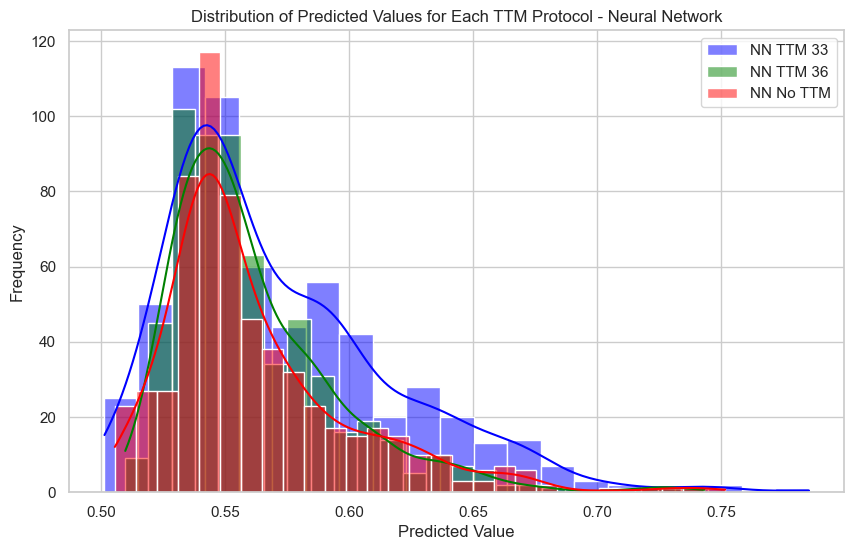

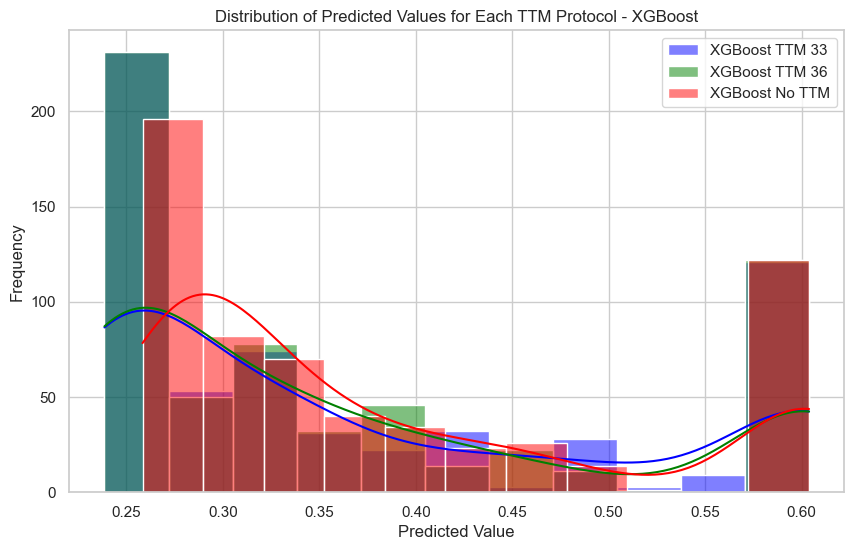

Neural Network Predictions - Number of data points for TTM 33: 607
Neural Network Predictions - Number of data points for TTM 36: 607
Neural Network Predictions - Number of data points for No TTM: 607
XGBoost Predictions - Number of data points for TTM 33: 607
XGBoost Predictions - Number of data points for TTM 36: 607
XGBoost Predictions - Number of data points for No TTM: 607


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for Neural Network predictions
plt.figure(figsize=(10, 6))
sns.histplot(combined_predictions_df['NN_Pred_TTM_33'], color="blue", label="NN TTM 33", kde=True)
sns.histplot(combined_predictions_df['NN_Pred_TTM_36'], color="green", label="NN TTM 36", kde=True)
sns.histplot(combined_predictions_df['NN_Pred_No_TTM'], color="red", label="NN No TTM", kde=True)
plt.title("Distribution of Predicted Values for Each TTM Protocol - Neural Network")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Set up the figure for XGBoost predictions
plt.figure(figsize=(10, 6))
sns.histplot(combined_predictions_df['xgb_Pred_TTM_33'], color="blue", label="XGBoost TTM 33", kde=True)
sns.histplot(combined_predictions_df['xgb_Pred_TTM_36'], color="green", label="XGBoost TTM 36", kde=True)
sns.histplot(combined_predictions_df['xgb_Pred_No_TTM'], color="red", label="XGBoost No TTM", kde=True)
plt.title("Distribution of Predicted Values for Each TTM Protocol - XGBoost")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Calculate the number of data points for each TTM protocol in NN predictions
num_points_nn_ttm_33 = combined_predictions_df['NN_Pred_TTM_33'].notnull().sum()
num_points_nn_ttm_36 = combined_predictions_df['NN_Pred_TTM_36'].notnull().sum()
num_points_nn_no_ttm = combined_predictions_df['NN_Pred_No_TTM'].notnull().sum()

# Calculate the number of data points for each TTM protocol in XGBoost predictions
num_points_xgb_ttm_33 = combined_predictions_df['xgb_Pred_TTM_33'].notnull().sum()
num_points_xgb_ttm_36 = combined_predictions_df['xgb_Pred_TTM_36'].notnull().sum()
num_points_xgb_no_ttm = combined_predictions_df['xgb_Pred_No_TTM'].notnull().sum()

# Display the counts
print(f"Neural Network Predictions - Number of data points for TTM 33: {num_points_nn_ttm_33}")
print(f"Neural Network Predictions - Number of data points for TTM 36: {num_points_nn_ttm_36}")
print(f"Neural Network Predictions - Number of data points for No TTM: {num_points_nn_no_ttm}")

print(f"XGBoost Predictions - Number of data points for TTM 33: {num_points_xgb_ttm_33}")
print(f"XGBoost Predictions - Number of data points for TTM 36: {num_points_xgb_ttm_36}")
print(f"XGBoost Predictions - Number of data points for No TTM: {num_points_xgb_no_ttm}")


# Let them vote

In [14]:
# Filter rows where both NN and XGBoost Best_Prediction match and differ from Original_TTM
changed_protocol_df = combined_predictions_df[
    (combined_predictions_df['Best_Prediction_NN'] == combined_predictions_df['Best_Prediction_XGB']) &  # NN and XGBoost best predictions are the same
    (combined_predictions_df['Best_Prediction_NN'] != combined_predictions_df['Original_TTM'])           # They differ from the original TTM
]

# Display the filtered DataFrame
changed_protocol_df


,Patient,Original_TTM,Outcome,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM,NN_TTM_33_Asses,NN_TTM_36_Asses,NN_No_TTM_Asses,xgb_TTM_33_Asses,xgb_TTM_36_Asses,xgb_No_TTM_Asses,Best_Prediction_NN,Best_Prediction_XGB
28,352,36,1,0.665704,0.604267,0.623257,0.482250,0.447286,0.447286,Same,Original TTM,Same,Same,Original TTM,Same,33,33
60,387,36,1,0.644313,0.581860,0.605729,0.437252,0.403010,0.403010,Same,Original TTM,Same,Same,Original TTM,Same,33,33
67,396,33,0,0.516168,0.551758,0.551976,0.240703,0.240703,0.277403,Original TTM,Same,Same,Original TTM,Same,Same,No TTM,No TTM
82,413,36,1,0.650568,0.612758,0.635324,0.482250,0.447286,0.447286,Same,Original TTM,Same,Same,Original TTM,Same,33,33
108,440,33,0,0.519137,0.556121,0.550975,0.348533,0.348533,0.416750,Original TTM,Same,Same,Original TTM,Same,Same,No TTM,No TTM
124,458,33,0,0.533527,0.551949,0.559507,0.240703,0.240703,0.277403,Original TTM,Same,Same,Original TTM,Same,Same,No TTM,No TTM
125,459,33,0,0.512148,0.550471,0.551735,0.240155,0.240155,0.275830,Original TTM,Same,Same,Original TTM,Same,Same,No TTM,No TTM
141,475,36,1,0.618729,0.564327,0.578815,0.437252,0.403010,0.403010,Same,Original TTM,Same,Same,Original TTM,Same,33,33
162,504,36,1,0.612922,0.566671,0.576526,0.435272,0.401075,0.401075,Same,Original TTM,Same,Same,Original TTM,Same,33,33
183,530,36,0,0.629098,0.577646,0.598922,0.434997,0.400806,0.400806,Same,Original TTM,Same,Same,Original TTM,Same,33,33


In [15]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Create a new column 'Overall_Best_TTM' in combined_predictions_df
combined_predictions_df['Overall_Best_TTM'] = combined_predictions_df.apply(
    lambda row: row['Best_Prediction_NN'] if row['Best_Prediction_NN'] == row['Best_Prediction_XGB'] else row['Original_TTM'],
    axis=1
)

# Step 2: Define a function to create the Sankey diagram based on 'Overall_Best_TTM'
def create_sankey_with_overall_best(data):
    # Count the transitions from Original_TTM to Overall_Best_TTM
    sankey_data = data.groupby(['Original_TTM', 'Overall_Best_TTM']).size().reset_index(name='count')
    
    # Calculate total patients in each Original_TTM group
    group_totals = sankey_data.groupby('Original_TTM')['count'].transform('sum')
    
    # Calculate percentage within each Original_TTM group
    sankey_data['percentage'] = (sankey_data['count'] / group_totals * 100).round(1)
    
    # Define unique nodes for original and best protocols
    original_nodes = [f"Original {protocol}" for protocol in sankey_data['Original_TTM'].unique()]
    best_nodes = [f"Overall Best {protocol}" for protocol in sankey_data['Overall_Best_TTM'].unique()]
    nodes = original_nodes + best_nodes
    
    # Map each node to a unique index for Sankey
    node_map = {node: i for i, node in enumerate(nodes)}
    
    # Define the sources, targets, values, and labels for the Sankey diagram
    sankey_data['source'] = sankey_data['Original_TTM'].map(lambda x: node_map[f"Original {x}"])
    sankey_data['target'] = sankey_data['Overall_Best_TTM'].map(lambda x: node_map[f"Overall Best {x}"])
    sources = sankey_data['source'].tolist()
    targets = sankey_data['target'].tolist()
    values = sankey_data['count'].tolist()
    
    # Use the group percentage labels for each link
    labels = [f"{percentage}%" for percentage in sankey_data['percentage']]
    
    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
        ),
        link=dict(
            source=sources,  # Indices of source nodes
            target=targets,  # Indices of target nodes
            value=values,    # Flow values between nodes
            label=labels     # Group percentage labels on each link
        )
    ))
    
    # Add title and display
    fig.update_layout(title_text="Sankey Diagram of TTM Protocol Changes (Original to Overall Best Prediction)", font_size=12)
    fig.show()

# Step 3: Generate the Sankey diagram using the updated DataFrame with 'Overall_Best_TTM'
create_sankey_with_overall_best(combined_predictions_df)


In [16]:
import pandas as pd

# List of numerical and categorical columns based on `patient_data`
numerical_cols = ['age', 'rosc']
categorical_cols = ['sex', 'ohca', 'ttm', 'shockable_rhythm']

# Ensure `changed_protocol_original` is defined by merging `changed_protocol_df` with `patient_data`
changed_protocol_original = changed_protocol_df.merge(
    patient_data[['Patient'] + numerical_cols + categorical_cols],
    on='Patient',
    suffixes=('_standardized', '_original')
)

# Dictionary to store results for each transition type
results = {}

# List of protocol transitions to analyze
transitions = [
    ('33', '36'),
    ('36', '33'),
    ('33', 'No TTM'),
    ('36', 'No TTM'),
    ('No TTM', '33'),
    ('No TTM', '36')
]

# Calculate means/modes for each specific transition type using original values
for original, best in transitions:
    # Filter for the specific transition where both NN and XGB agree on the best prediction
    transition_df = changed_protocol_original[
        (changed_protocol_original['Original_TTM'] == original) &
        (changed_protocol_original['Best_Prediction_NN'] == best) &
        (changed_protocol_original['Best_Prediction_XGB'] == best)
    ]
    
    if not transition_df.empty:
        # Calculate mean values for numerical features
        feature_means_original = transition_df[numerical_cols].mean()
        
        # Calculate mode for categorical features
        feature_modes_original = transition_df[categorical_cols].mode().iloc[0]
        
        # Count of cases for this transition
        num_cases = len(transition_df)
        
        # Add the count of cases as the first row in the result
        combined_features = pd.concat([pd.Series({'Number of Cases': num_cases}), feature_means_original, feature_modes_original])
        
        # Store the results in a dictionary with the transition name as the key
        results[f'{original} to {best}'] = combined_features

# Convert the results dictionary to a DataFrame for easier comparison
comparison_df = pd.DataFrame(results)

# Display the comparison table with original values, including categorical feature modes
comparison_df


,36 to 33,33 to No TTM,No TTM to 33
Number of Cases,10,12,1
age,58.7,72.833333,37.0
rosc,NaN,36.0,16.0
sex,Male,Female,Female
ohca,Unknown,True,False
ttm,36.0,33.0,No TTM
shockable_rhythm,Unknown,True,True


In [17]:
combined_predictions_df.describe()

,Patient,Outcome,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,668.588138,0.370675,0.571694,0.561554,0.562158,0.368957,0.364796,0.382331
std,204.331564,0.483384,0.045890,0.034566,0.038561,0.136601,0.133800,0.123572
min,284.000000,0.000000,0.501261,0.509638,0.505425,0.238660,0.238660,0.258379
25%,488.500000,0.000000,0.538577,0.537000,0.538749,0.250766,0.251144,0.278793
50%,673.000000,0.000000,0.557676,0.551873,0.549715,0.321075,0.318803,0.326089
75%,846.500000,1.000000,0.596398,0.577664,0.575157,0.482250,0.445435,0.452638
max,1020.000000,1.000000,0.785387,0.743231,0.751571,0.603810,0.603810,0.603810
